# Notebook for visualizing the results of a stylegan3 training


In [1]:
import os, json
import matplotlib.pyplot as plt

results_dir = "training-runs/OITAVEN"
experiment_name = "00001-stylegan3-t-oitaven-gpus2-batch64-gamma0.125"
# results_dir = "training-runs/MNIST"
# experiment_name = "00003-stylegan3-t-mnist-gpus2-batch64-gamma0.125"

file_name = "stats.jsonl"

file_path = os.path.join(results_dir, experiment_name, file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file {file_path} does not exist.")

# Labels for the classes
class_labels = range(10)

In [2]:
import numpy as np

class_colors = {
    0: "#f4341c",
    1: "#744c14",
    2: "#bbbbbb",
    3: "#5c6474",
    4: "#fae53a",
    5: "#ec8c3c",
    6: "#93d664",
    7: "#52b450",
    8: "#76933f",
    9: "#036400",
}


def read_jsonl(file_path):
    """Reads a JSONL file and returns a list of parsed JSON objects."""
    with open(file_path, "r") as f:
        return [json.loads(line) for line in f]


def extract_metrics(jsonl_data, class_labels):
    """Extracts metrics from JSONL data into a dictionary of lists."""
    metric_keys = [
        "Loss/scores/fake",
        "Loss/signs/fake",
        "Loss/G/loss",
        "Loss/scores/real",
        "Loss/signs/real",
        "Loss/D/loss",
        "Loss/r1_penalty",
        "Loss/D/reg",
        "Progress/tick",
        "Progress/kimg",
        "Timing/total_sec",
        "Timing/sec_per_tick",
        "Timing/sec_per_kimg",
        "Timing/maintenance_sec",
        "Resources/cpu_mem_gb",
        "Resources/peak_gpu_mem_gb",
        "Resources/peak_gpu_mem_reserved_gb",
        "Progress/augment",
        "Timing/total_hours",
        "Timing/total_days",
        "Timing/Gboth",
        "Timing/Dmain",
        "Timing/Dreg",
        "timestamp",
    ]
    metric_keys.extend([f"Accuracy/{c}" for c in class_labels])
    metrics = {key: [] for key in metric_keys}

    for entry in jsonl_data:
        for key in metric_keys:
            value = entry.get(key, None)
            if isinstance(value, dict) and "mean" in value:
                metrics[key].append(value["mean"])
            else:
                metrics[key].append(value)
    return metrics


def extract_classification_metrics(jsonl_data, class_labels):
    """
    Extracts classification metrics (mean and num) from the JSONL data into a dictionary.
    """
    classification_keys = [f"Accuracy/{c}" for c in class_labels]
    metrics = {key: {"mean": [], "num": []} for key in classification_keys}

    for entry in jsonl_data:
        for key in classification_keys:
            if key in entry:
                # Handle nested keys with "mean" and "num" values
                if isinstance(entry[key], dict):
                    metrics[key]["mean"].append(entry[key].get("mean", None))
                    metrics[key]["num"].append(entry[key].get("num", None))
                else:
                    metrics[key]["mean"].append(None)
                    metrics[key]["num"].append(None)
            else:
                metrics[key]["mean"].append(None)
                metrics[key]["num"].append(None)

    return metrics


def extract_confusion_matrix(jsonl_data, class_labels, progress_tick=None):
    """Extracts confusion matrix data from JSONL data."""
    num_classes = len(class_labels)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    entry = jsonl_data[-1] if progress_tick is None else jsonl_data[progress_tick]

    for real_class in class_labels:
        for pred_class in class_labels:
            key = f"Classification/{real_class}/{pred_class}"
            if key in entry:
                value = entry[key]
                if isinstance(value, dict) and "mean" in value and "num" in value:
                    confusion_matrix[real_class, pred_class] = int(value["mean"] * value["num"])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, class_labels):
    """Plots a confusion matrix with a heatmap and text annotations."""
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(
                j,
                i,
                int(confusion_matrix[i, j]),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black",
            )

    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()


def plot_metric(data, metrics, x_axis="Progress/kimg", colors=None, marker="o", title=None, ylim=None):
    """Plots specific metrics against the x-axis."""
    plt.figure(figsize=(10, 5))
    for i, metric in enumerate(metrics):
        if metric in data:
            color = colors[i] if colors and i < len(colors) else None
            plt.plot(data[x_axis], data[metric], label=metric, color=color, marker=marker)
    plt.xlabel(x_axis)
    plt.ylabel("Metric Value")
    if ylim:
        plt.ylim(ylim)
    plt.title(title or f"{', '.join(metrics)} vs {x_axis}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


def print_accuracies_per_class(data, class_labels, last_ticks=10):
    """
    Prints the accuracies for each class from the classification loss metrics.
    """
    classification_keys = [f"Accuracy/{c}" for c in class_labels]
    accuracies = [data[metric][-last_ticks:] for metric in classification_keys]
    accuracies = np.array(accuracies)
    print(f"Last {last_ticks} accuracies per class:")
    for class_label, acc in zip(class_labels, accuracies):
        print(f"Class {class_label}: {acc}")
    print(f"Average accuracies over the last {last_ticks} ticks: {np.mean(accuracies, axis=0)}")


def compute_avg_accuracy(data, clean_nan, class_labels):
    """
    Computes the average accuracy from the classification loss metrics.
    """
    classification_keys = [f"Accuracy/{c}" for c in class_labels]
    accuracies = [data[metric] for metric in classification_keys]
    if clean_nan:
        accuracies = [np.nan_to_num(acc, nan=0) for acc in accuracies]

    accuracies = np.array(accuracies)
    return np.mean(accuracies, axis=0), np.std(accuracies, axis=0)


def compute_overall_accuracy(classification_metrics):
    """
    Computes the overall accuracy from the classification metrics.
    """
    total_correct = None
    total_samples = None

    for key, values in classification_metrics.items():
        means = np.array(values["mean"])
        means = np.nan_to_num(means, nan=0.0)
        nums = np.array(values["num"])

        if total_correct is None:
            total_correct = np.zeros_like(means)
            total_samples = np.zeros_like(nums)

        total_correct += means * nums
        total_samples += nums

    return total_correct / total_samples


def plot_accuracies(data, class_labels=range(10), plot_std_in_avg_accuracy=True, plot_type="both"):
    """
    Plots the overall accuracy, average accuracy, or both over time.

    Args:
        data (dict): Dictionary containing the metrics data.
        class_labels (list): List of class labels (default is range(10)).
        plot_std_in_avg_accuracy (bool): Whether to plot the standard deviation in the average accuracy plot.
        plot_type (str): Type of plot to generate. Options are:
                         - "overall": Plot only overall accuracy.
                         - "average": Plot only average accuracy.
                         - "both": Plot both overall and average accuracy in the same plot.
    """
    if plot_type not in ["overall", "average", "both"]:
        raise ValueError("Invalid plot_type. Choose from 'overall', 'average', or 'both'.")

    # Plot Overall Accuracy
    if plot_type in ["overall", "both"]:
        overall_accuracy = data["overall_accuracy"]
        plt.figure(figsize=(10, 5))
        plt.plot(data["Progress/kimg"], overall_accuracy, label="Overall Accuracy", marker="o")
        plt.xlabel("Progress/kimg")
        plt.ylabel("Overall Accuracy")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if plot_type == "overall":
            plt.title("Overall Accuracy vs Progress/kimg")
            plt.show()

    # Compute Average Accuracy and Standard Deviation
    if plot_type in ["average", "both"]:
        avg_accuracy, std_accuracy = compute_avg_accuracy(data, clean_nan=True, class_labels=class_labels)

        if plot_type == "average":
            plt.figure(figsize=(10, 5))
        plt.plot(data["Progress/kimg"], avg_accuracy, label="Average Accuracy", marker="o")
        if plot_std_in_avg_accuracy:
            plt.fill_between(
                data["Progress/kimg"],
                avg_accuracy - std_accuracy,
                avg_accuracy + std_accuracy,
                alpha=0.2,
                label="Standard Deviation",
            )
        plt.xlabel("Progress/kimg")
        plt.ylabel("Average Accuracy")
        if plot_type == "average":
            plt.title("Average Accuracy vs Progress/kimg")
        else:
            plt.title("Overall and Average Accuracy vs Progress/kimg")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.close("all")


import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(confusion_matrix, class_labels):
    """
    Plots a confusion matrix with a heatmap and text annotations.

    Args:
        confusion_matrix (np.ndarray): 2D NumPy array representing the confusion matrix.
        class_labels (list): List of class labels corresponding to the rows and columns of the matrix.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Add labels to the axes
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    # Add text annotations in each cell
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(
                j,
                i,
                int(confusion_matrix[i, j]),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black",
            )

    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()

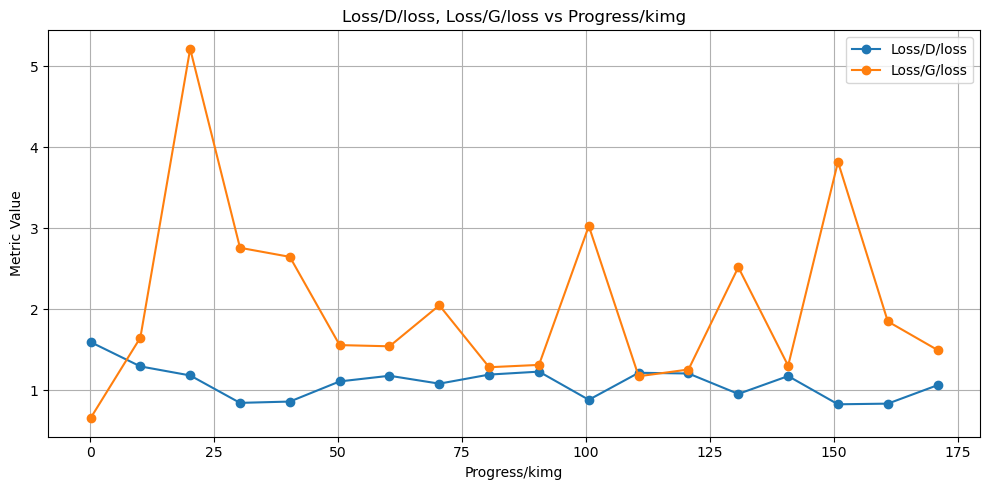

In [3]:
jsonl_data = read_jsonl(file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
plot_metric(metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg")

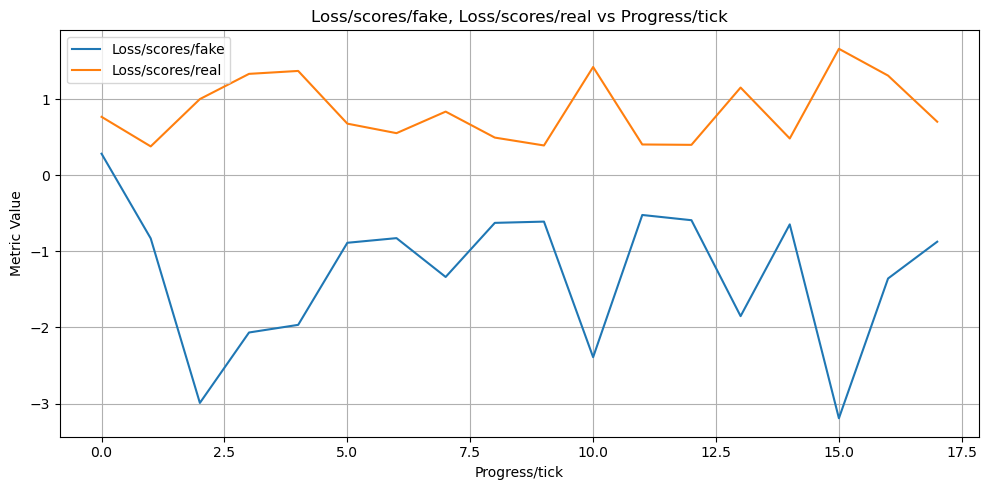

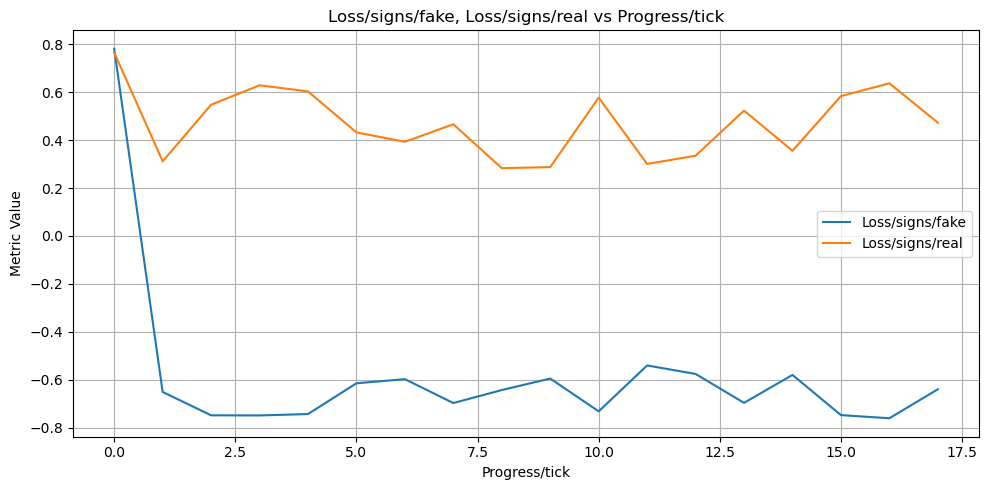

In [4]:
plot_metric(metrics, metrics=["Loss/scores/fake", "Loss/scores/real"], x_axis="Progress/tick", marker=None)
plot_metric(metrics, metrics=["Loss/signs/fake", "Loss/signs/real"], x_axis="Progress/tick", marker=None)

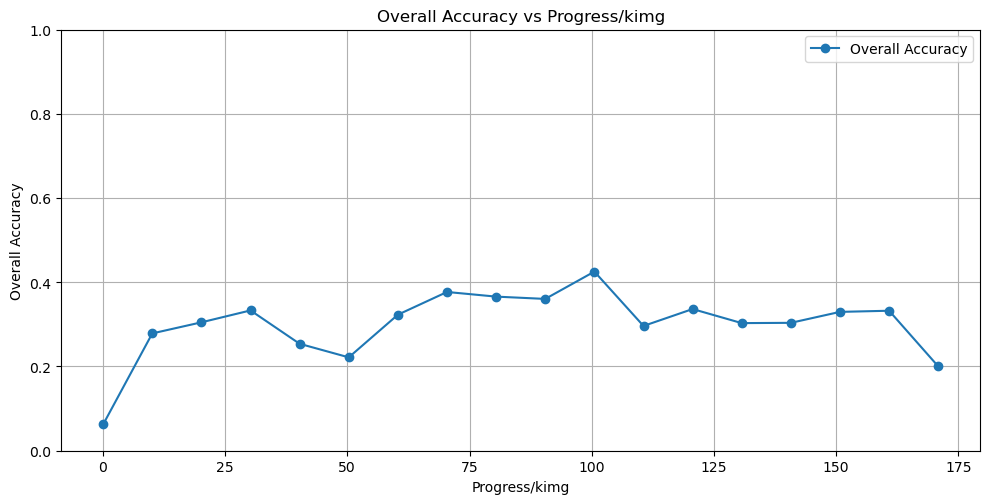

In [5]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy"] = compute_overall_accuracy(classification_metrics)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=False,
    plot_type="overall",
)

Last 10 accuracies per class:
Class 0: [0.23148148 0.16363636 0.43487859 0.15883669 0.14482759 0.08830022
 0.14922049 0.26639344 0.38571429 0.15367965]
Class 1: [0.00404858 0.0125     0.02953586 0.08641975 0.10169492 0.0876494
 0.05240175 0.05241935 0.22727273 0.15811966]
Class 2: [0.0104712  0.01234568 0.2        0.04878049 0.10365854 0.02247191
 0.05357143 0.14772727 0.05524862 0.15976331]
Class 3: [0.15384615 0.3        0.2        0.3        0.33333333 0.27941176
 0.18571429 0.35616438 0.53225806 0.62121212]
Class 4: [0.         0.01287554 0.01632653 0.08205128 0.10480349 0.12765957
 0.12       0.04807692 0.1038961  0.12727273]
Class 5: [0.16083916 0.17105263 0.25625    0.11805556 0.16428571 0.12582781
 0.26666667 0.20437956 0.20645161 0.21830986]
Class 6: [0.46111111 0.40203488 0.44182622 0.34407331 0.38379657 0.48388051
 0.34730009 0.35332542 0.43892461 0.21671095]
Class 7: [0.37043991 0.39664955 0.56088362 0.26879699 0.3166578  0.18076509
 0.27066279 0.27833954 0.16613419 0.15326

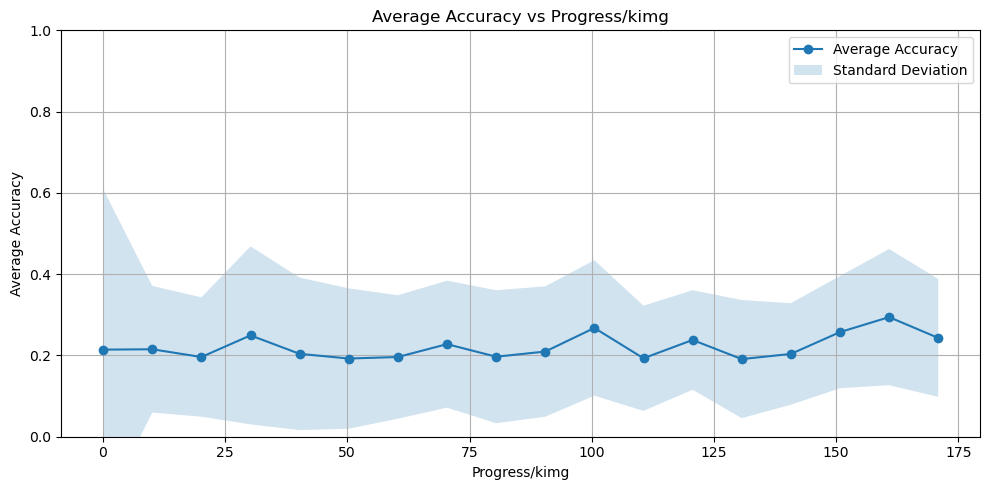

In [6]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
)

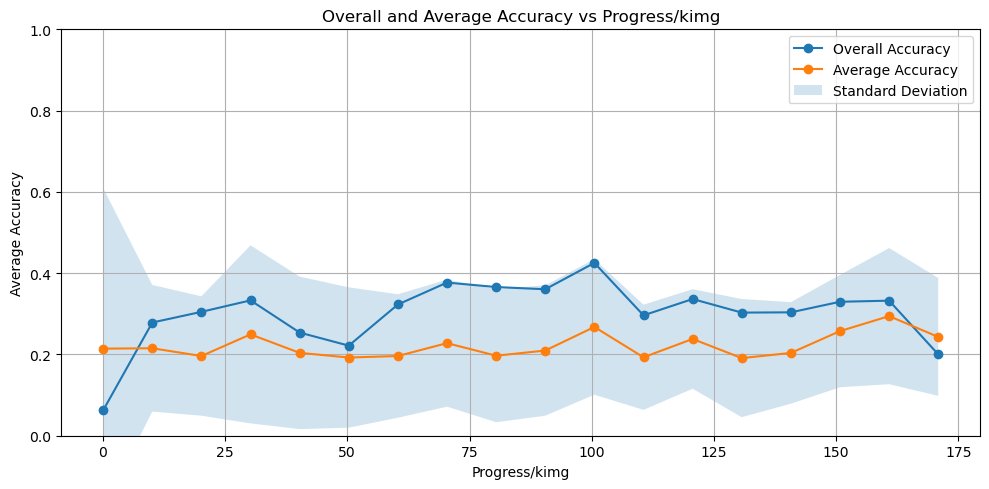

In [7]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
)

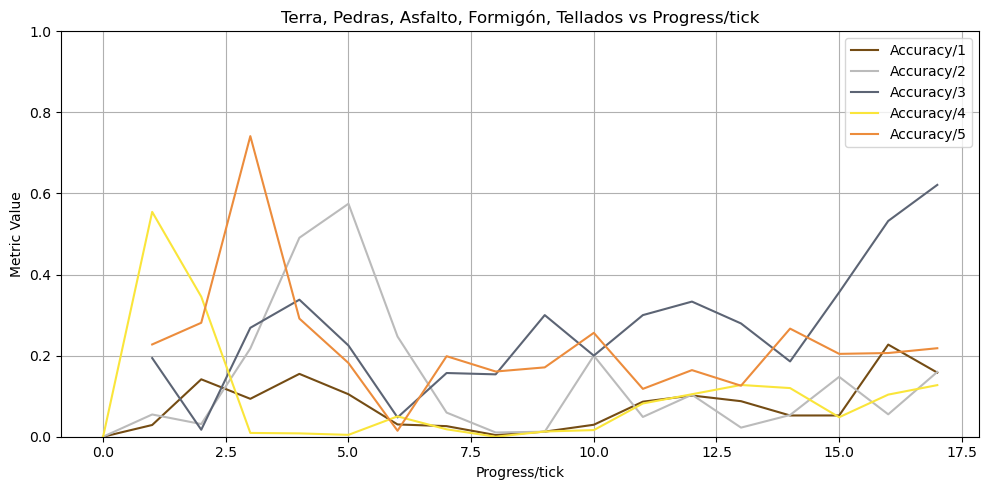

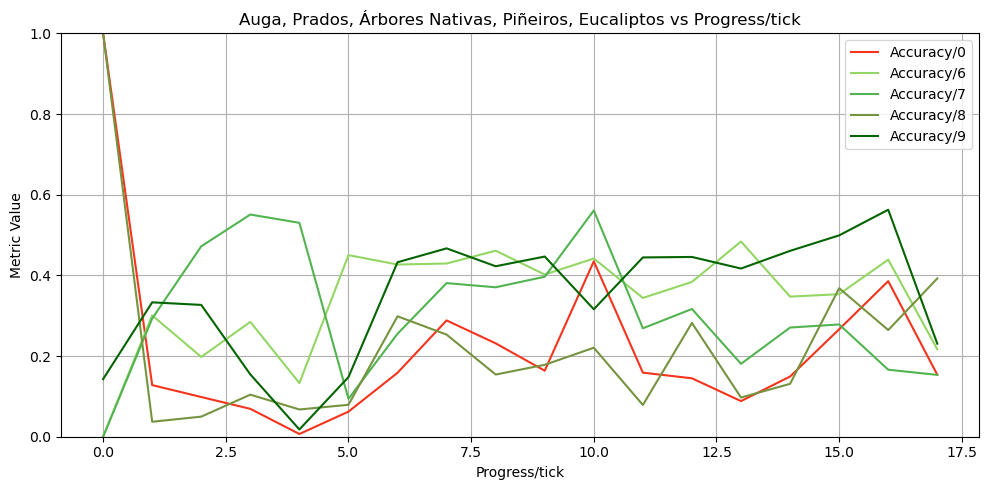

In [8]:
if "oitaven" in experiment_name:
    minority_class_labels = [1, 2, 3, 4, 5]
    colors = [class_colors[c] for c in minority_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/{c}" for c in minority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Terra, Pedras, Asfalto, Formigón, Tellados vs Progress/tick",
    )
    mayority_class_labels = [0, 6, 7, 8, 9]
    colors = [class_colors[c] for c in mayority_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/{c}" for c in mayority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Auga, Prados, Árbores Nativas, Piñeiros, Eucaliptos vs Progress/tick",
    )
else:
    first_class_labels = [0, 1, 2, 3, 4]
    colors = [class_colors[c] for c in first_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/{c}" for c in first_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="0, 1, 2, 3, 4 vs Progress/tick",
    )
    last_class_labels = [5, 6, 7, 8, 9]
    colors = [class_colors[c] for c in last_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/{c}" for c in last_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="5, 6, 7, 8, 9 vs Progress/tick",
    )

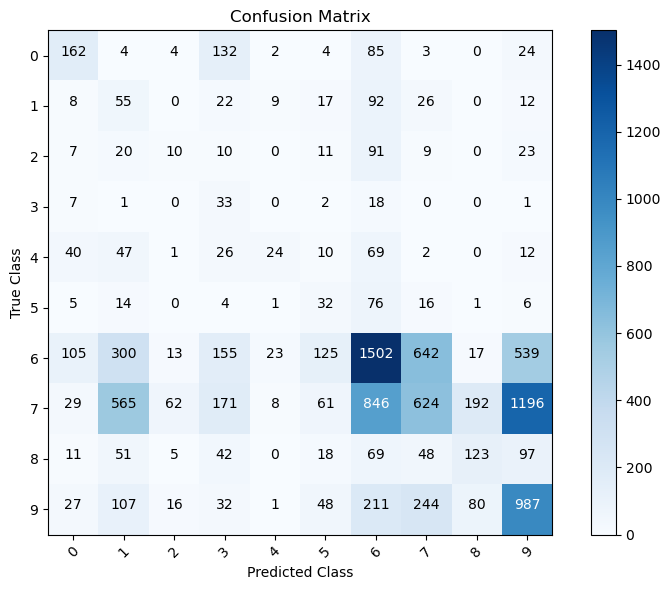

In [9]:
confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, progress_tick=16)
plot_confusion_matrix(confusion_matrix, class_labels=class_labels)